# Anomaly Detection (and SVD-III)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import slideUtilities as sl
import laUtilities as ut
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

Today we'll discuss an important topic related to unsupervised learning: __anomaly detection.__

Anomalies are objects that are different from most other objects.   

Anomalies are also called "outliers".

Furthermore, we usually expect that anomalies are different in a __qualitative__ sense as well.

> An outlier is an observation that differs so much from other observations as to arouse suspicion that it was generated by a different mechanism

-- Douglas Hawkins


Why might we be interested in anomalies?

* __Fraud Detection__ - stolen credit cards
* __Intrusion Detection__ - attacks on computer systems
* __Public Health__ - occurrence of disease in a particular area
* __Medicine__ - a set of symptoms may indicate a disease

Anomaly detection presents a number of challenges.

It is an __unsupervised__ method -- so validation is hard
* It is hard to know that your set of anomalies is correct
* It is hard to know how many anomalies there are in the data

The main assumption made in anomaly detection:

__There are many more "normal" observations than "abnormal" (anomalies) in the data.__

Methodologically, anomaly detection proceeds as follows:

1. Build a profile of "normal" data objects
    * These can be patterns, summary statistics, or more complicated models
2. Use the "normal" profile to detect anomalies
    * These are observations whose characteristics differ significantly from the normal profile.

## Approaches To Anomaly Detection

The idea that "normal behavior is what is most frequently observed" is the basis for most anomaly detection methods.

It suggests a number of approaches.

__Model-Based Methods.__

Here, we assume that a model for the data will describe most of the data.   What is not well described by the model are potentially anomalies.

1) Use the data to estimate the parameters of a probability distribution.   For example, one might estimate a normal distribution from the data.

* Then an object that is very unlikely under the model may be an anomaly.

2) Model the data as a set of clusters (cluster the data).

* Then an object that does not strongly belong to any cluster may be an anomaly.

3) Model the data using a regression.
* Then an object that is far from its predicted value may be an anomaly.

__Other Methods.__

If you cannot build a model of the data, you can still:

1. Define an anomaly as one that is distant from all (or most) other objects.
2. Define an anomaly as one that is in an unusually-low-density region.

## Anomaly Detection via the Low-Dimensional Phenomenon

The first application of the phenomenon is anomaly detection.

The anomaly detection problem is as follows: given a population $P$, divide the members of $P$ in a normal set $N$ and an anomalous set $O$.

The most common way to address this problem is to construct a distributional model for $N$ and identify the set $O$ as those that have low probability under this model.   More generally, one may try to use machine learning to build a classifier that separates $N$ and $O$.

The difficulty with these approaches is that they require labeled training data -- some ground truth separation of normal and anomalous items must be known in advance.

Instead, if the low-dimensional phenomenon holds, we can do a good job of anomaly detection __without__ any labeled data.

We make the assumption that in the dataset $P$, __the majority of data or users are normal.__

Then we can use the low-dimensional phenomenon to separate abnormal data from the population of normal data.

If $N$ is a set of users, this can be effective for cybersecurity, separating benign from misbehaving users.

In practice, given a set of measurements:

* Assume that “most” observations are normal
* Build a low-dimensional (linear) model for them
* What is not well predicted is anomalous and most likely some form of misbehavior


In practice, this is a simple process.

Given a data matrix $A$:

1.  Compute the Singular value decomposition of $A$, $$U\Sigma V^T = A.$$
2.  Compute a low-rank approximation to $A$, $$N = U'\Sigma'(V')^T.$$
3.  Compute the data not explained by $N$:  $$O = A-N.$$
4.  Indentify the rows of $O$ with largest $\ell_2$ norm: these rows correspond to anomalies.

There are two unspecified steps in the process:

1. Selecting the columns of $U$ to be used in forming $N$
2. Deciding how many of the largest rows of $O$ are anomalies.

For 1, the general idea is to choose a $k$ at the knee of the singular value plot.  
For 2, there are statistical methods that generally work reasonably well.

### Example 2: Facebook Spatial Likes

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, across the 210 content categories that Facebook assigns to pages.

Rows are users, Columns are categories.

First we'll look at the total number of likes for each user (the row sums).

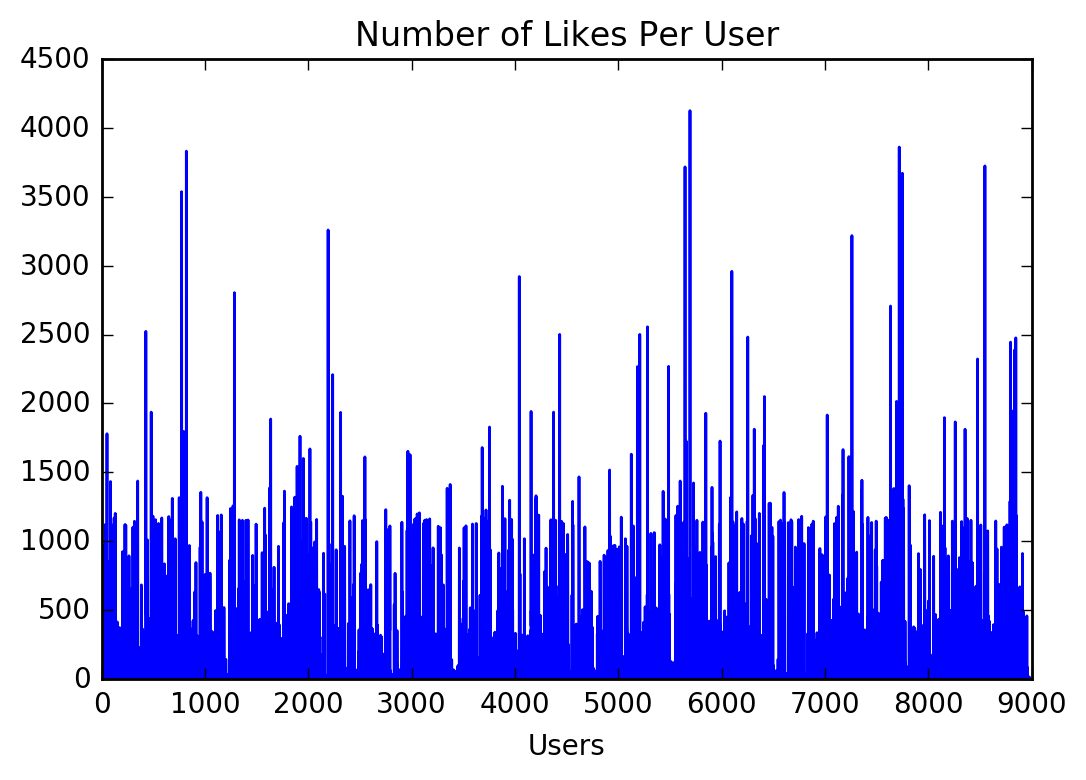

In [18]:
data = np.loadtxt('data/social/data/spatial_data.txt')
FBSpatial = data[:,1:]
FBSnorm = np.linalg.norm(FBSpatial,axis=1,ord=1)
plt.plot(FBSnorm)
plt.title('Number of Likes Per User')
plt.xlabel('Users')

Now let's check whether the low dimensional phenomenon holds.

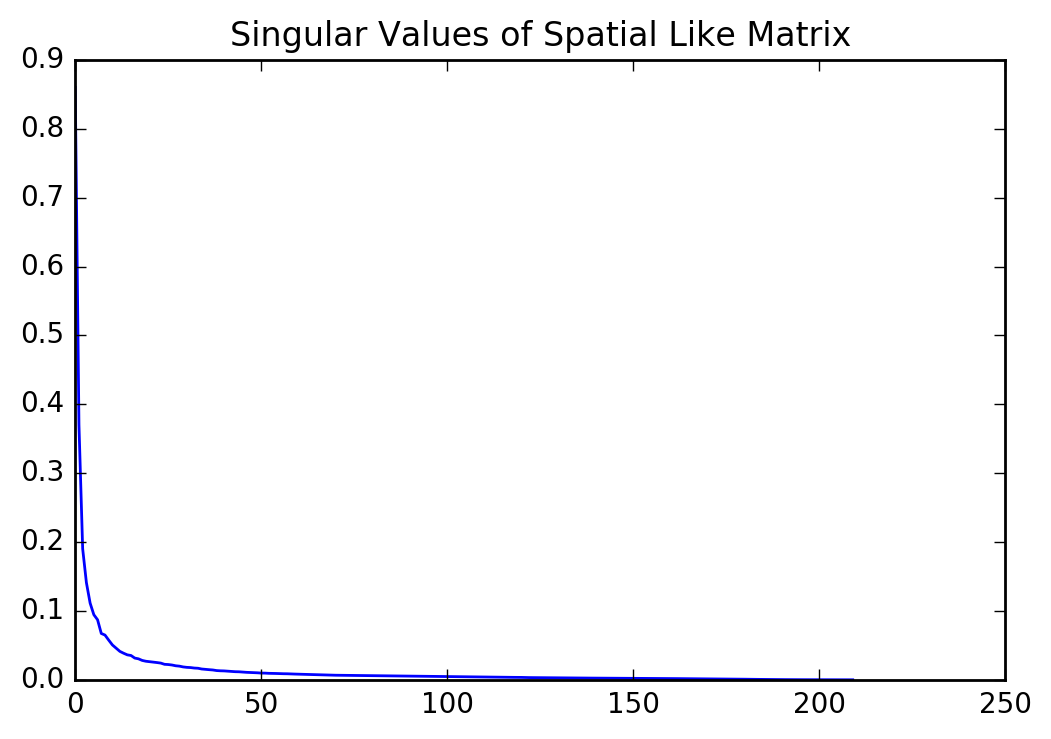

In [19]:
u,s,vt = np.linalg.svd(FBSpatial,full_matrices=False)
plt.plot(s/np.linalg.norm(FBSpatial))
plt.title('Singular Values of Spatial Like Matrix')

Now let's 

1. Separate the portion of the data lying in the normal space from the amonalous space,
2. Identify the top 30 anomalous users (having the largest anomalous component), and
3. Plot their total number of likes against the set of all users.

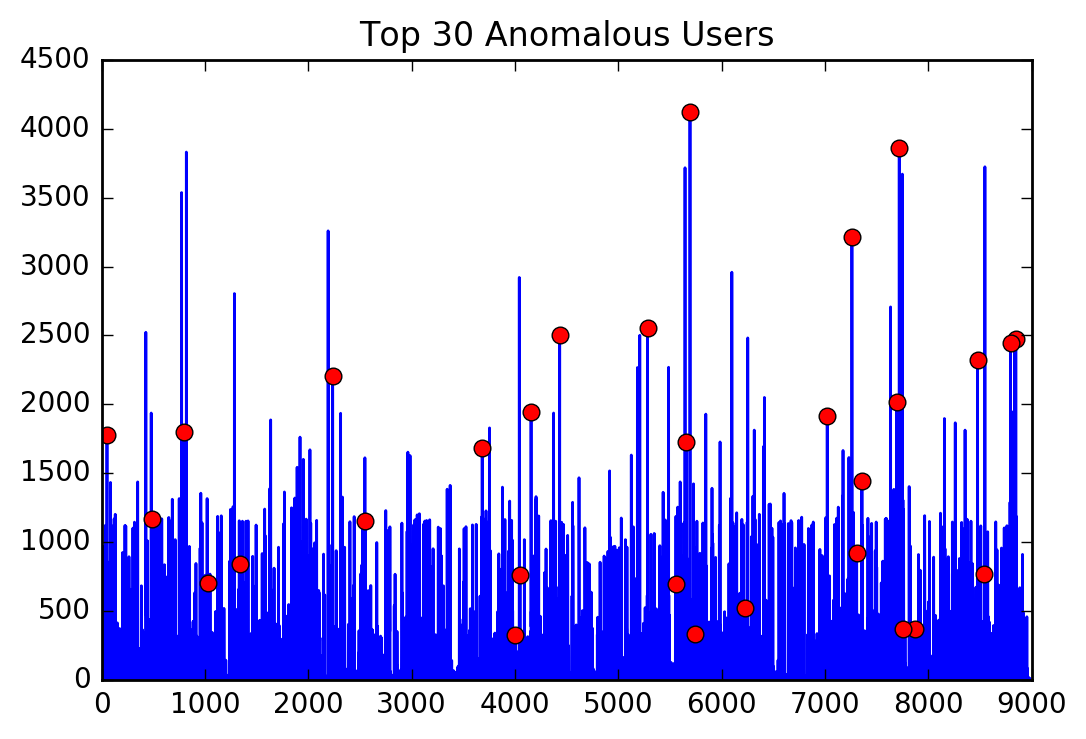

In [20]:
unorm = u[:,0:25]
P = unorm.dot(unorm.T)
N = P.dot(FBSpatial)
O = FBSpatial - N
Onorm = np.linalg.norm(O,axis=1)
# large = np.nonzero(Onorm>100))
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(FBSnorm)
plt.plot(anomSet,FBSnorm[anomSet],'ro')
plt.title('Top 30 Anomalous Users')

Next we'll pick out nine anomalous users and look at their pattern of likes across the 210 categories.

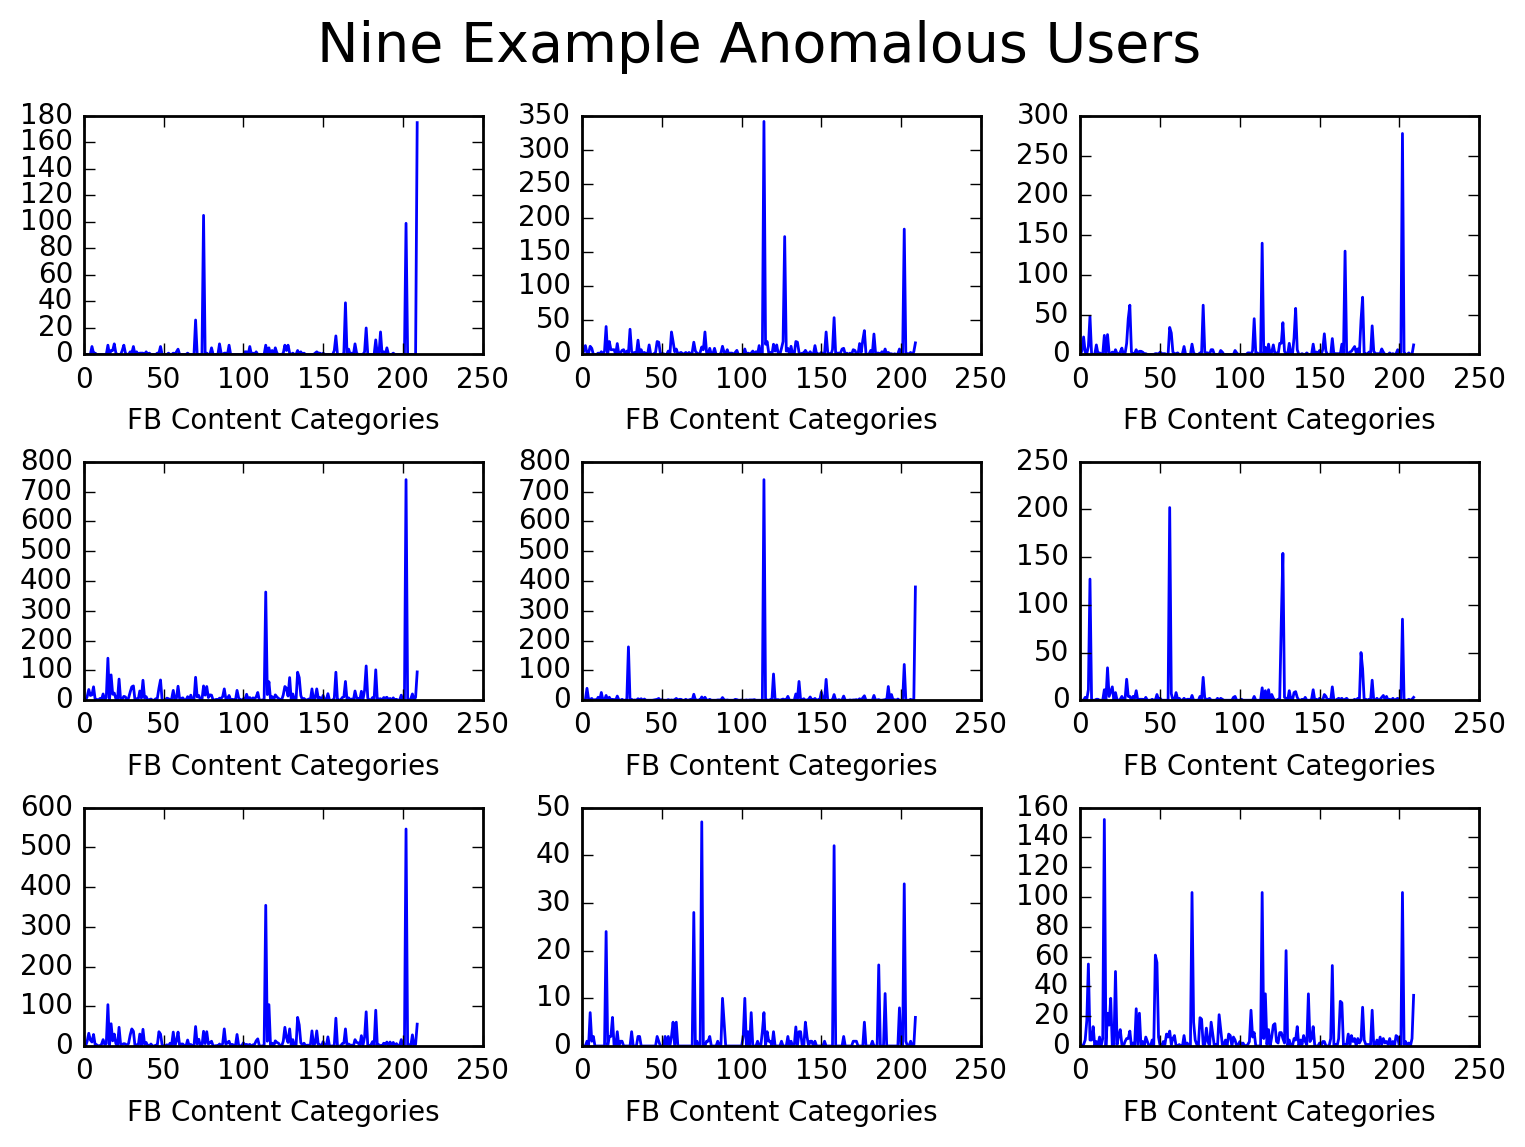

In [21]:
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[anomSet[i-1],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Users',size=20)

And let's do the same for nine normal users.

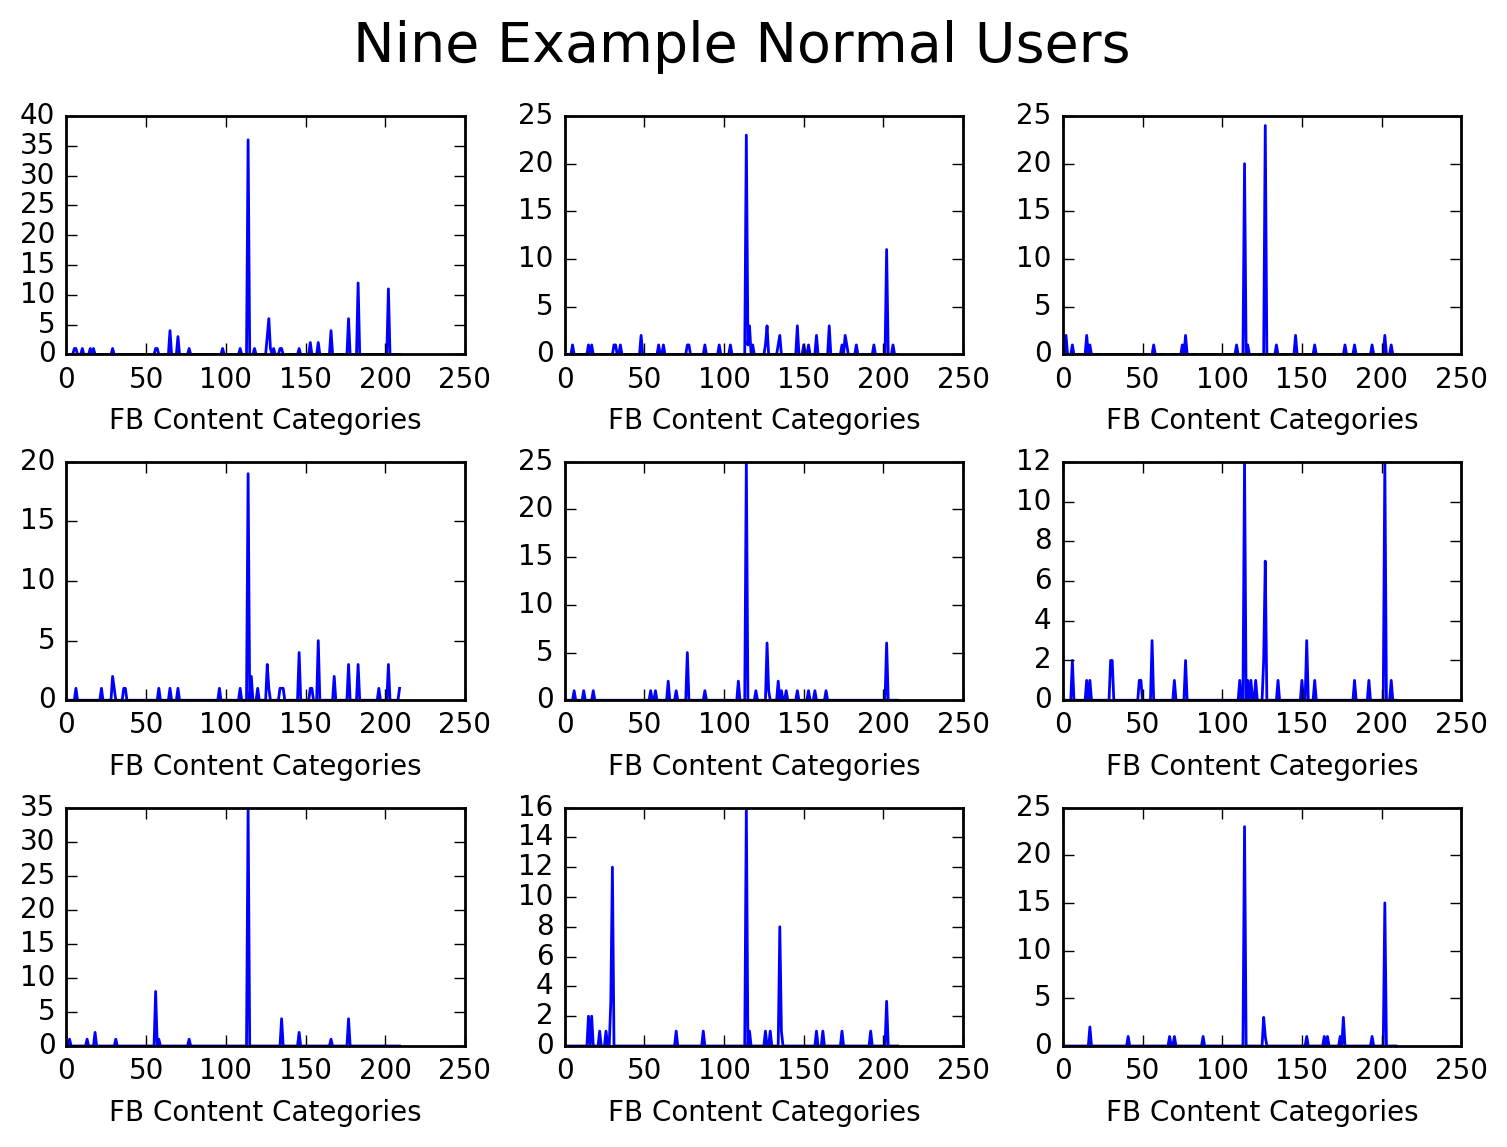

In [22]:
# choose non-anomalous users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBSnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[set[max[i-1]],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Users',size=20)

### Example 3: Facebook Temporal LIkes

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, on a daily basis

Rows are users, Columns are days.

First we'll look at the singular values.

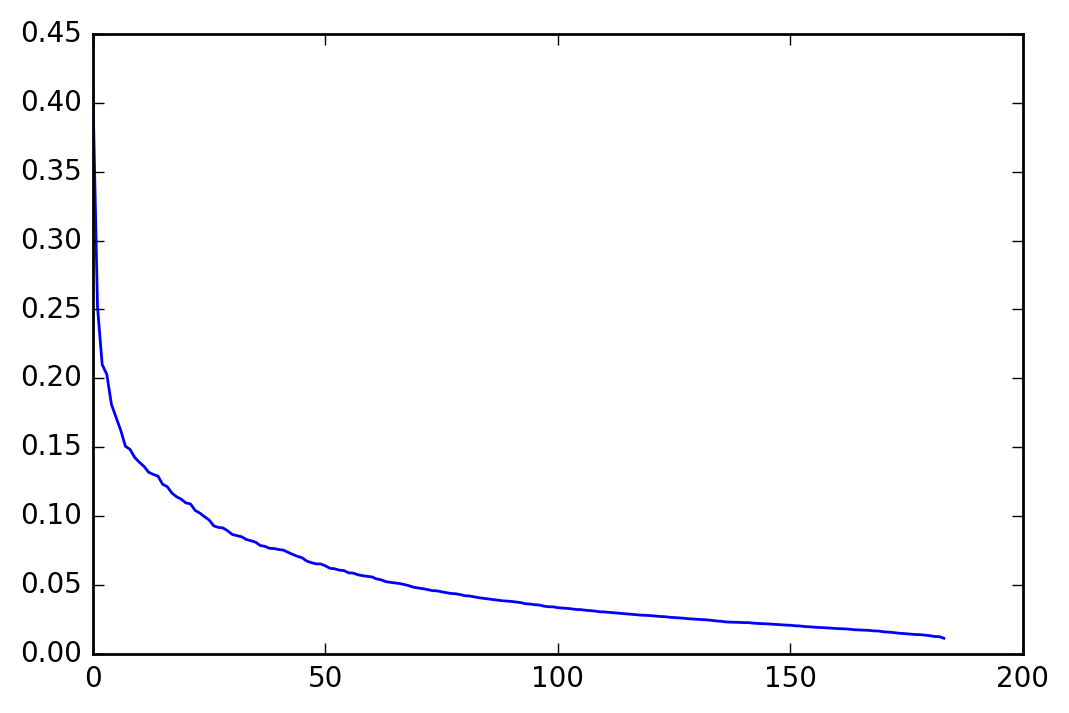

In [23]:
data = np.loadtxt('data/social/data/temporal_data.txt')
FBTemporal = data[:,1:]
FBTnorm = np.linalg.norm(FBTemporal,axis=1,ord=1)
u,s,vt = np.linalg.svd(FBTemporal,full_matrices=False)
plt.plot(s/np.linalg.norm(FBTemporal))

Next, plot the anomalous users as before.

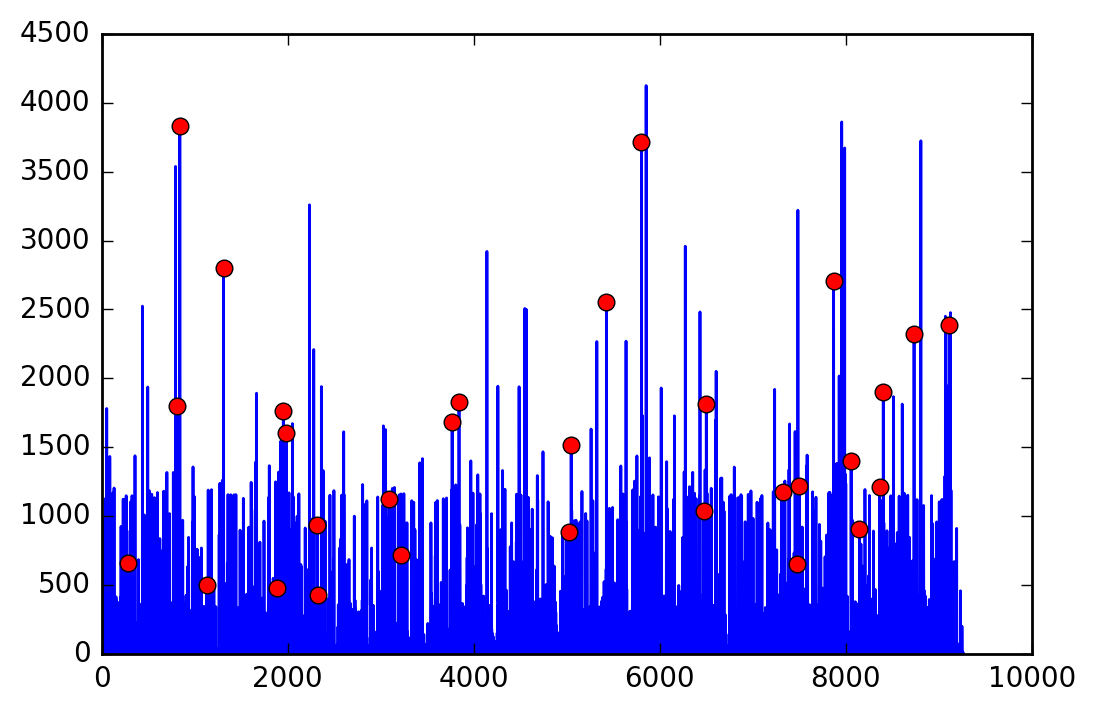

In [24]:
# choose the top 25 columns of U for the normal space
unorm = u[:,0:24]
P = unorm.dot(unorm.T)
N = P.dot(FBTemporal)
O = FBTemporal - N
Onorm = np.linalg.norm(O,axis=1)
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(FBTnorm)
plt.plot(anomSet,FBTnorm[anomSet],'ro')

Now let's look at sample anomalous and normal users.   

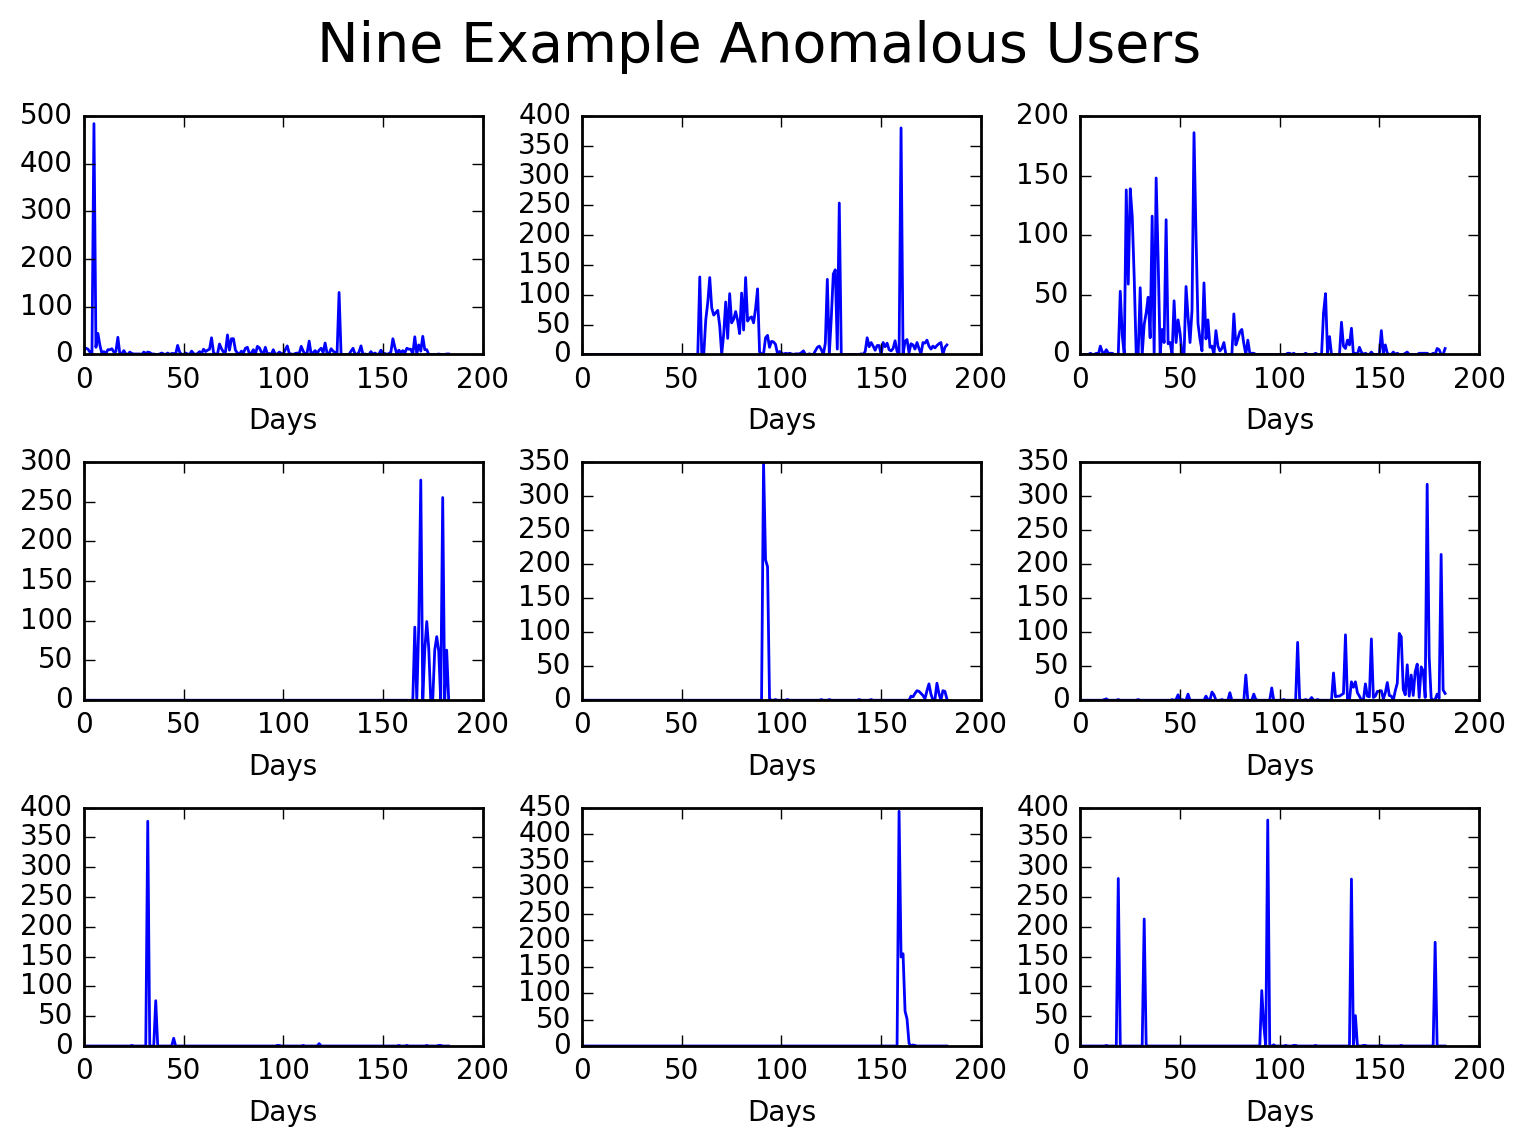

In [25]:
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBTemporal[anomSet[i-1],:])
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Users',size=20)

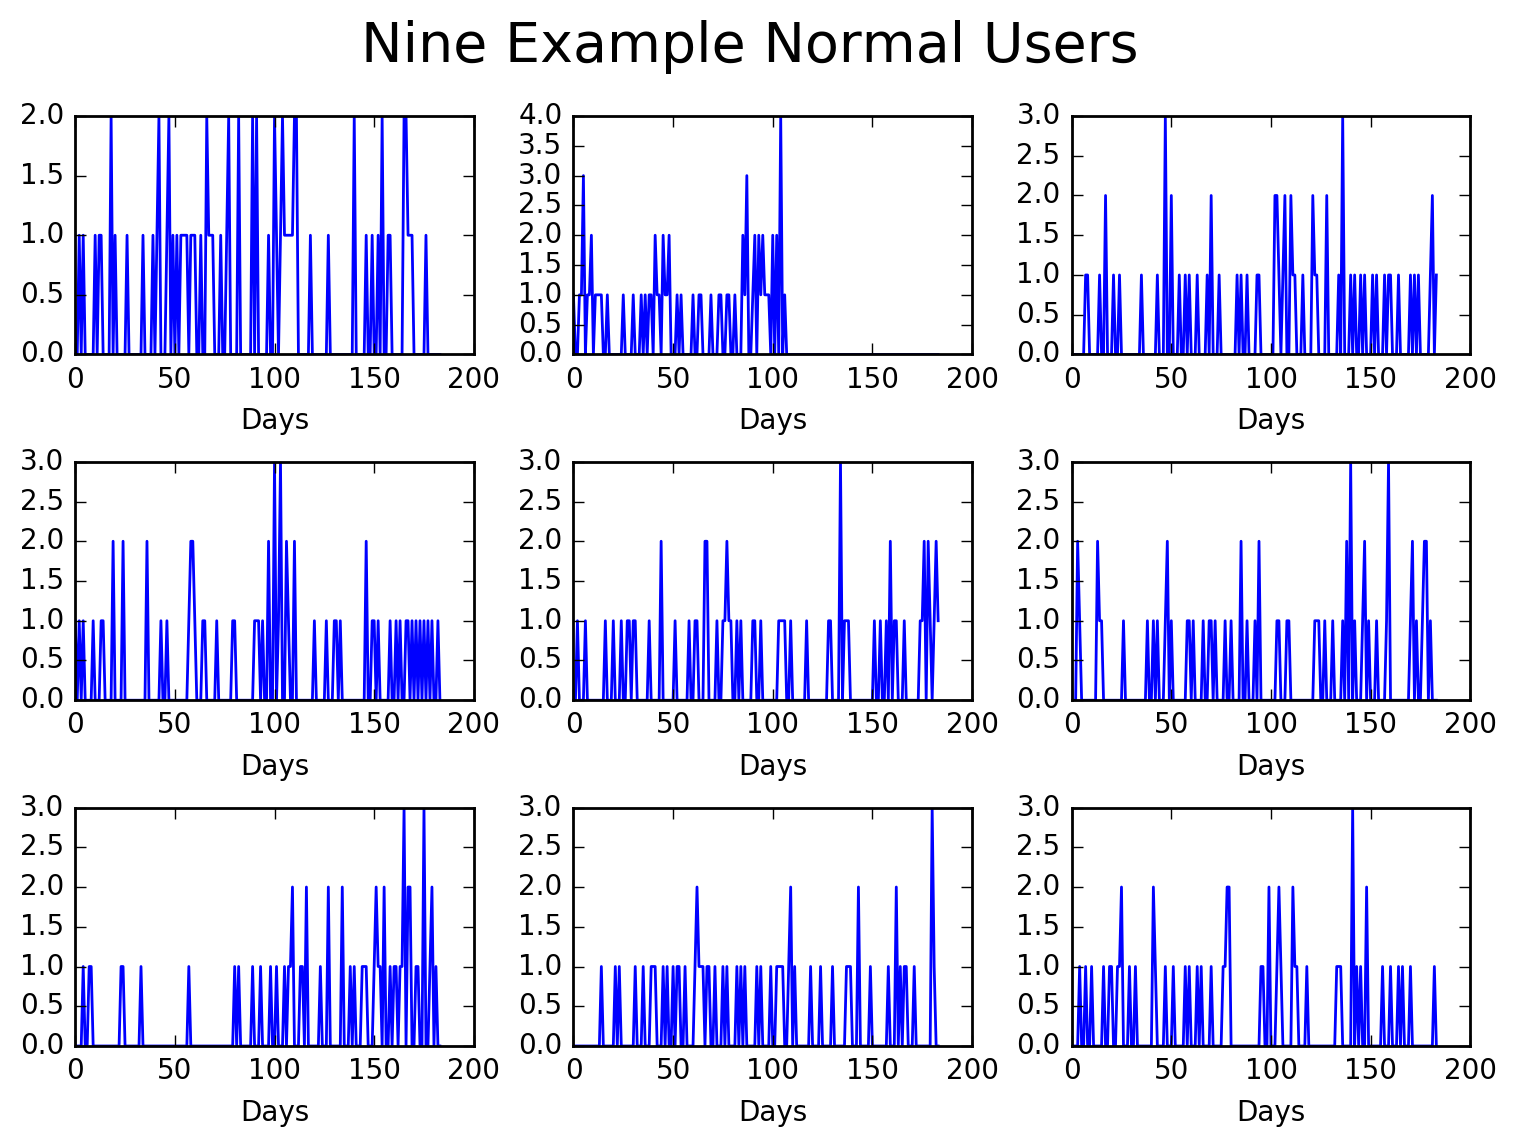

In [26]:
# choose non-anomalous users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBTnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBTemporal[set[max[i-1]],:])
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Users',size=20)

Interestingly, what makes a user anomalous seems to have reversed from the case of the spatial data.